<a href="https://colab.research.google.com/github/constance-moore2001/Thinkful/blob/master/OD_and_MAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction:**

Substance Use Disorder is of significant concern in the US, in particular drug related overdose. I propose to investigate geographical differencess in drug related overdose; and whether or not Medication-Assisted Treatment (MAT) is associated with a reduction in drug related overdose in CA.

The questions and hypotheses are:

1: Are there geographic differences in drug overdose deaths?
  I hypothesize that deaths due to drug overdose will be higher in regions with lower socioeconomic status.

2: Is there a correlation between drug overdose and MAT for California?
  I hypothesize that deaths due to drug overdose will decrease with increasing MAT.


# **2. Data and Method:**

Data for this proposal came from HealthData.gov:

1: Vital Statistics Rapid Release Provisional Drug Overdose Death Counts (VSSR) - https://healthdata.gov/dataset/vsrr-provisional-drug-overdose-death-counts

2: Medication-Assisted Treatment in Medi-Cal for Opioid Use Disorders, by Count (MAT) - https://healthdata.gov/dataset/medication-assisted-treatment-medi-cal-opioid-use-disorders-county

The ***VSSR*** data is a CSV file and linkable. The set contains 12 columns and 28544 rows, with data from 49 states (does not incude HI), District of Columbia, and NYC. The data is quarterly from 2015 to 2019:

1: State (Abbreviated state name)

2: Year (2015, 2016, 2017, 2018, 2019)

3: Month (Varied)                          

4: Period (12-month ending)                      

5: Indicator (Drug name, overdose deaths, total deaths)

6: Data Value (NaN for drug name, number of overdose deaths, number of total deaths)

7: Percent Complete (Percent deaths not under investigation)

8: Percent Pending Investigation (Percent deaths not under investigation)

9: State Name (Complete state name)

10: Footnote                         

11: Footnote Symbol                 

12: Predicted Value (Predicted deaths).

The ***MAT*** data is a CSV file and linkable. The set contains 1429 rows and 6 columns, with data from CA as a wole and each county. The data is yearly from 2010 to 2018:

1: County (CA and CA counties)       

2: Year (2010 through 2018)                     

3: Beneficiaries (Number of people receiveing MAT through Medi-Cal)

4: MAT (Buprenorphine, Methadone Program, Naloxone)		            

5: Annotation                

6: Annotation Description.

For the first question, I will divide the data by time zones, pooling for Pacific Time, Mountain Times, Central and Eastern. If the data is normal, I will use a one way Anova, otherwise the Kruskal-Wallis test. A post-hoc analysis will be conducted to look for specific differences, if this is indicated.

For the second question I will look at the MAT data for CA, and the drug overdose deaths for CA from 2015 to 2019, using pearson’s correlation, or spearman’s rho if non-parametric.


# **3. Data Preparation and Exploration Question 1**

Are there geographic differences in drug overdose deaths? I hypothesize that deaths due to drug overdose will be higher in regions with lower socioeconomic status.

In [0]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

In [0]:
CDC_state_deaths = pd.read_csv("https://data.cdc.gov/api/views/xkb8-kh2a/rows.csv?accessType=DOWNLOAD")
CDC_state_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28545 entries, 0 to 28544
Data columns (total 12 columns):
State                            28545 non-null object
Year                             28545 non-null int64
Month                            28545 non-null object
Period                           28545 non-null object
Indicator                        28545 non-null object
Data Value                       23677 non-null float64
Percent Complete                 28545 non-null object
Percent Pending Investigation    28545 non-null float64
State Name                       28545 non-null object
Footnote                         28545 non-null object
Footnote Symbol                  28545 non-null object
Predicted Value                  18021 non-null float64
dtypes: float64(3), int64(1), object(8)
memory usage: 2.6+ MB


In [0]:
CDC_state_deaths.head()

,State,Year,Month,Period,Indicator,Data Value,Percent Complete,Percent Pending Investigation,State Name,Footnote,Footnote Symbol,Predicted Value
0,AK,2015,April,12 month-ending,Cocaine (T40.5),NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN
1,AK,2015,April,12 month-ending,Heroin (T40.1),NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN
2,AK,2015,April,12 month-ending,Natural & semi-synthetic opioids (T40.2),NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN
3,AK,2015,April,12 month-ending,Percent with drugs specified,88.095238,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN
4,AK,2015,April,12 month-ending,"Opioids (T40.0-T40.4,T40.6)",NaN,100,0.0,Alaska,Numbers may differ from published reports usin...,**,NaN


3.1. Extract rows from Indicator: number of overdose deaths, number of total deaths. Drop columns not of interest and rename, Indicator column.

In [0]:
OD_deaths = CDC_state_deaths[CDC_state_deaths['Indicator']=='Number of Drug Overdose Deaths']
all_deaths = CDC_state_deaths[CDC_state_deaths['Indicator']=='Number of Deaths']
OD_deaths_clean = OD_deaths.drop(["Period", 'Indicator', "Percent Complete", 'Percent Pending Investigation', 'State Name', 'Footnote', 'Footnote Symbol', 'Predicted Value'], axis=1)
OD_deaths_clean.rename(columns={'Data Value':'ODDeaths'}, inplace=True)
all_deaths_clean = all_deaths.drop(["Period", 'Indicator', "Percent Complete", 'Percent Pending Investigation', 'State Name', 'Footnote', 'Footnote Symbol', 'Predicted Value'], axis=1)
all_deaths_clean.rename(columns={'Data Value':'AllDeaths'}, inplace=True)

3.2. Merge OD_deaths and all_deaths into a single dataframe.

In [0]:
state_OD_all_deaths = all_deaths_clean.merge(OD_deaths_clean, how = 'inner', on = ['State', 'Year', 'Month'])
state_OD_all_deaths.head()

,State,Year,Month,AllDeaths,ODDeaths
0,AK,2015,April,4133.0,126.0
1,AK,2015,August,4222.0,124.0
2,AK,2015,December,4193.0,121.0
3,AK,2015,February,4084.0,127.0
4,AK,2015,January,4034.0,126.0


3.3. Calculate percent OD and create a new column.

In [0]:
state_OD_all_deaths['percentOD'] = (state_OD_all_deaths.ODDeaths * 100/state_OD_all_deaths.AllDeaths)
state_OD_all_deaths.head()

,State,Year,Month,AllDeaths,ODDeaths,percentOD
0,AK,2015,April,4133.0,126.0,3.048633
1,AK,2015,August,4222.0,124.0,2.936997
2,AK,2015,December,4193.0,121.0,2.885762
3,AK,2015,February,4084.0,127.0,3.109696
4,AK,2015,January,4034.0,126.0,3.123451


3.4. Clean up dates: month as a digit and create a new column with Day, Month, Year.

In [0]:
state_OD_all_deaths['Month'] = pd.to_datetime(state_OD_all_deaths['Month'], format='%B').dt.month
state_OD_all_deaths['Date'] = pd.to_datetime(state_OD_all_deaths.assign(Day=1).loc[:, ['Year','Month','Day']])
state_OD_all_deaths.head()

,State,Year,Month,AllDeaths,ODDeaths,percentOD,Date
0,AK,2015,4,4133.0,126.0,3.048633,2015-04-01
1,AK,2015,8,4222.0,124.0,2.936997,2015-08-01
2,AK,2015,12,4193.0,121.0,2.885762,2015-12-01
3,AK,2015,2,4084.0,127.0,3.109696,2015-02-01
4,AK,2015,1,4034.0,126.0,3.123451,2015-01-01


3.5 Create dataframe for geograpical locations. Divide into West, Mid-West, South, North-East and NYC.



In [0]:
def label_states (row):
    if row['state'] in ['AK','WA', 'OR', 'CA', 'NV','MT','ID','UT', 'CO', 'AZ', 'NM','WY']:
        return 'West'
    if row['state'] in ['ND', 'SD', 'NE', 'KS','MN','IA','MO','MI','IN','WI','IL','OH']:
        return 'Mid-West'
    if row['state'] in ['OK', 'TX', 'AR', 'LA', 'TN', 'MS', 'AL','KY', 'GA','FL','WV', 'VA', 'NC', 'SC', 'DE', 'MD', 'DC']:
        return 'South'
    if row['state'] in ['NY', 'CT', 'MA', 'PA','RI', 'NH','NJ','VT', 'ME']:
        return 'North-East'
    if row['state'] in ['YC']:
        return 'NYC'
    return 'etc'

state_geo = pd.DataFrame([{'state':"YC"},{'state':"NC"},{'state':"SC"},{'state':"MI"},{'state':"CT"},{'state':"MA"},{'state':"OH"},{'state':"PA"},{'state':"MD"}, {'state':"VT"},{'state':"ME"},{'state':"DC"},{'state':"NJ"},{'state':"DE"},{'state':"NH"}, {'state':"RI"}, {'state':"WV"},{'state':"VA"},{'state':"IN"},{'state':"KY"},{'state':"GA"},{'state':"FL"},{'state':"NY"},{'state':"AR"},{'state':"LA"},{'state':"TN"},{'state':"MS"},{'state':"AL"},{'state':"IL"},{'state':"IA"},{'state':"KS"},{'state':"MO"},{'state':"OK"},{'state':"TX"},{'state':"WI"},{'state':"MN"},{'state':"AK"}, {'state':"WA"}, {'state':"OR"}, {'state':"CA"}, {'state':"NV"}, {'state':"MT"}, {'state':"ID"}, {'state':"ND"}, {'state':"SD"},{'state':"WY"}, {'state':"UT"}, {'state':"CO"}, {'state':"AZ"}, {'state':"NM"}, {'state':"NE"}])

state_geo['Region'] = state_geo.apply(lambda row: label_states(row), axis=1)

state_geo.head()

,state,Region
0,YC,NYC
1,NC,South
2,SC,South
3,MI,Mid-West
4,CT,North-East


3.6. Merge with OD dataframe.

In [0]:
state_OD_all_deaths_region = state_OD_all_deaths.merge(state_geo, left_on='State', right_on='state',
          suffixes=('_left', '_right'))

In [0]:
state_OD_all_deaths_region.head()

,State,Year,Month,AllDeaths,ODDeaths,percentOD,Date,state,Region
0,AK,2015,4,4133.0,126.0,3.048633,2015-04-01,AK,West
1,AK,2015,8,4222.0,124.0,2.936997,2015-08-01,AK,West
2,AK,2015,12,4193.0,121.0,2.885762,2015-12-01,AK,West
3,AK,2015,2,4084.0,127.0,3.109696,2015-02-01,AK,West
4,AK,2015,1,4034.0,126.0,3.123451,2015-01-01,AK,West


3.7. Explore the Data.

In [0]:
state_OD_all_deaths_region.describe()

,Year,Month,AllDeaths,ODDeaths,percentOD
count,2805.000000,2805.000000,2805.000000,2805.000000,2805.000000
mean,2016.818182,6.181818,54139.479857,1215.826381,2.274058
std,1.336324,3.406970,52760.104688,1208.604340,0.926642
min,2015.000000,1.000000,4034.000000,55.000000,0.640342
25%,2016.000000,3.000000,17048.000000,332.000000,1.554699
50%,2017.000000,6.000000,43445.000000,849.000000,2.167766
75%,2018.000000,9.000000,66095.000000,1576.000000,2.800433
max,2019.000000,12.000000,272905.000000,5768.000000,6.068268


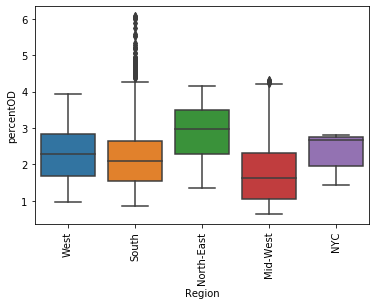

In [0]:
ax = sns.boxplot(y="percentOD", x = "Region", data=state_OD_all_deaths_region)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

3.8. Divide dataframe into regions and look for normal distribution. 

In [0]:
OD_West = state_OD_all_deaths_region.iloc[(state_OD_all_deaths_region['Region'] == 'West').values]
OD_South = state_OD_all_deaths_region.iloc[(state_OD_all_deaths_region['Region'] == 'South').values]
OD_North_East = state_OD_all_deaths_region.iloc[(state_OD_all_deaths_region['Region'] == 'North-East').values]
OD_Mid_West = state_OD_all_deaths_region.iloc[(state_OD_all_deaths_region['Region'] == 'Mid-West').values]
OD_NYC = state_OD_all_deaths_region.iloc[(state_OD_all_deaths_region['Region'] == 'NYC').values]

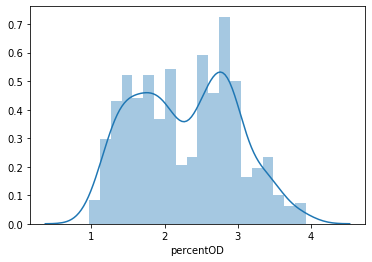

In [0]:
ax = sns.distplot(OD_West['percentOD'], bins=20)

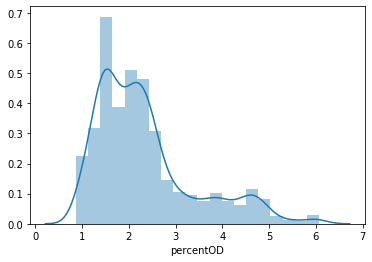

In [0]:
ax = sns.distplot(OD_South['percentOD'], bins=20)

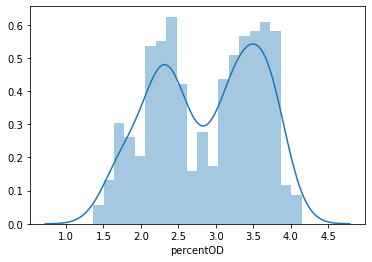

In [0]:
ax = sns.distplot(OD_North_East['percentOD'], bins=20)

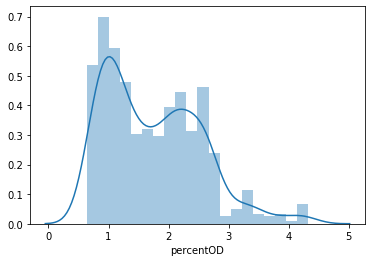

In [0]:
ax = sns.distplot(OD_Mid_West['percentOD'], bins=20)

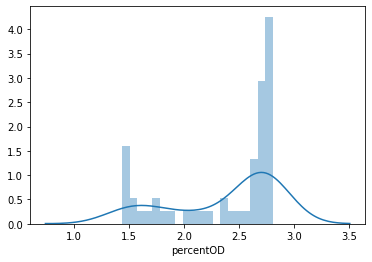

In [0]:
ax = sns.distplot(OD_NYC['percentOD'], bins=20)

In [0]:
# None of the above  look like a normal distribution. Will look at The Shapiro–Wilk test as a test of normality.
print(stats.shapiro(OD_West['percentOD']))
print(stats.shapiro(OD_South['percentOD']))
print(stats.shapiro(OD_North_East['percentOD']))
print(stats.shapiro(OD_Mid_West['percentOD']))
print(stats.shapiro(OD_NYC['percentOD']))

(0.9695234298706055, 1.7539122931786721e-10)
(0.8801968097686768, 3.1530206469396125e-26)
(0.9476246237754822, 3.173170710565887e-12)
(0.9321097731590271, 9.87715193625889e-17)
(0.767726719379425, 6.140661668041503e-08)


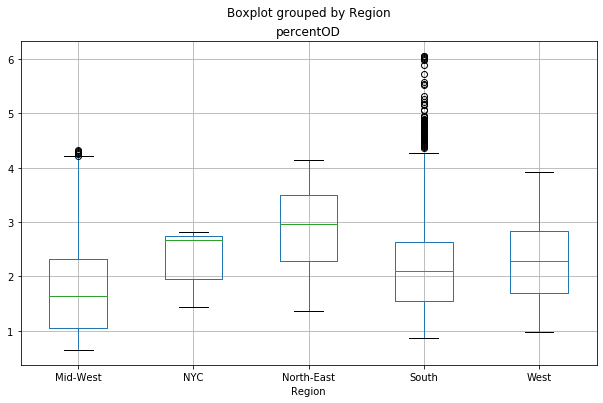

In [0]:
state_OD_all_deaths_region.boxplot('percentOD', by='Region', figsize=(10, 6))

3.9. Do Kruskal–Wallis test for a non-parametric data.

In [0]:
# There are clearly significant geogrpahical differences. 
stats.kruskal(OD_West['percentOD'], OD_South['percentOD'], OD_North_East['percentOD'], OD_Mid_West['percentOD'], OD_NYC['percentOD'])

KruskalResult(statistic=491.7017778004696, pvalue=4.175901778424829e-105)

3.10. Do Tukey post-hoc.

In [0]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = state_OD_all_deaths_region['percentOD'],     
                          groups = state_OD_all_deaths_region['Region'],  
                          alpha=0.05)  
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Mid-West,NYC,0.6323,0.001,0.3052,0.9595,True
Mid-West,North-East,1.1277,0.001,0.9891,1.2663,True
Mid-West,South,0.5853,0.001,0.4668,0.7038,True
Mid-West,West,0.5337,0.001,0.4054,0.6621,True
NYC,North-East,0.4954,0.001,0.1641,0.8267,True
NYC,South,-0.0471,0.9,-0.3705,0.2764,False
NYC,West,-0.0986,0.9,-0.4257,0.2285,False
North-East,South,-0.5425,0.001,-0.672,-0.4129,True
North-East,West,-0.594,0.001,-0.7326,-0.4554,True
South,West,-0.0515,0.7317,-0.17,0.067,False


Contrary to the hypothesis, OD deaths greatest in the North-East.


# **4. Data Preparation and Exploration Question 2**

Is there a correlation between drug overdose and Medication-Assisted Treatment(MAT) for California?
  I hypothesize that deaths due to drug overdose will decrease with increasing MAT.

4.1. Upload MAT data from CDC as CA_MAT.

Extract statewide data from the CA_MAT dataframe.

In [0]:
MAT = pd.read_csv("https://data.chhs.ca.gov/dataset/8329a339-ab77-4d05-ab7a-405d0ae5765c/resource/bf66ffea-8f37-4553-8829-4bf9286e7802/download/imd-mat-for-opioid-use-yearly-oct-2019.csv")
CA_MAT = MAT[MAT['County']=='Statewide']
CA_MAT.head(10)

,County,Year,Beneficiaries,MAT,Annotation,Annotation Description
0,Statewide,2010,1268.0,Buprenorphine,None,None
1,Statewide,2011,1551.0,Buprenorphine,None,None
2,Statewide,2012,1837.0,Buprenorphine,None,None
3,Statewide,2013,1855.0,Buprenorphine,None,None
4,Statewide,2014,4518.0,Buprenorphine,None,None
5,Statewide,2015,8633.0,Buprenorphine,None,None
6,Statewide,2016,12876.0,Buprenorphine,None,None
7,Statewide,2017,16797.0,Buprenorphine,None,None
8,Statewide,2018,21216.0,Buprenorphine,None,None
477,Statewide,2010,20439.0,Methadone Program,None,None


4.2. Drop unwanted columns from CA_MAT data frame.

In [0]:
CA_MAT = CA_MAT.drop(["County", 'Annotation', "Annotation Description"], axis=1)
CA_MAT.head()

,Year,Beneficiaries,MAT
0,2010,1268.0,Buprenorphine
1,2011,1551.0,Buprenorphine
2,2012,1837.0,Buprenorphine
3,2013,1855.0,Buprenorphine
4,2014,4518.0,Buprenorphine


4.3. Explore Data.

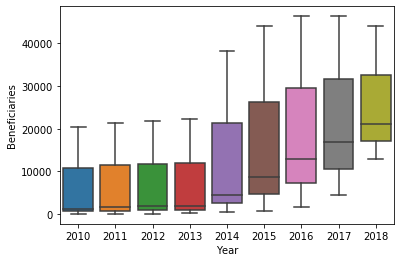

In [0]:
ax = sns.boxplot(y="Beneficiaries", x = "Year", data=CA_MAT)

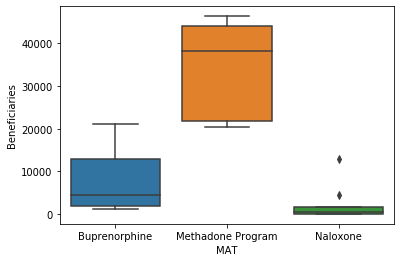

In [0]:
ax = sns.boxplot(y="Beneficiaries", x = "MAT", data=CA_MAT)

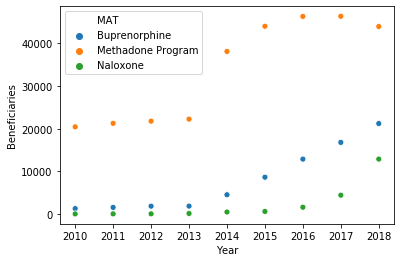

In [0]:
ax = sns.scatterplot(y="Beneficiaries", x = "Year", hue= 'MAT', data=CA_MAT)

4.4. Group all MAT treatments together, by year.



In [0]:
CA_MAT_yearly = CA_MAT.groupby('Year').agg('sum').reset_index()
CA_MAT_yearly.head()

,Year,Beneficiaries
0,2010,21728.0
1,2011,22846.0
2,2012,23654.0
3,2013,24238.0
4,2014,43112.0


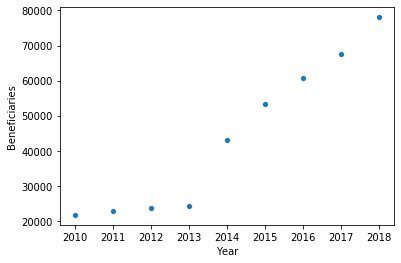

In [0]:
ax = sns.scatterplot(y="Beneficiaries", x = "Year", data=CA_MAT_yearly)

4.5. Extract yearly data from OD_CA

In [0]:
OD_CA_yearly = OD_CA.groupby('Year').agg('sum').reset_index()
OD_CA_yearly.head()

,Year,Month,AllDeaths,ODDeaths,percentOD
0,2015,78,3056952.0,56001.0,21.983580
1,2016,78,3139581.0,57154.0,21.845712
2,2017,78,3202053.0,58406.0,21.885766
3,2018,78,3262105.0,63121.0,23.220583
4,2019,28,1871340.0,39469.0,14.763312


In [0]:
OD_CA_yearly['percentOD'] = (OD_CA_yearly.ODDeaths * 100/OD_CA_yearly.AllDeaths)
OD_CA_yearly.head()

,Year,Month,AllDeaths,ODDeaths,percentOD
0,2015,78,3056952.0,56001.0,1.831923
1,2016,78,3139581.0,57154.0,1.820434
2,2017,78,3202053.0,58406.0,1.824017
3,2018,78,3262105.0,63121.0,1.934978
4,2019,28,1871340.0,39469.0,2.109130


4.6. Extract OD_CA data from CDC data.

In [0]:
OD_deaths = CDC_state_deaths[CDC_state_deaths['Indicator']=='Number of Drug Overdose Deaths']
all_deaths = CDC_state_deaths[CDC_state_deaths['Indicator']=='Number of Deaths']
OD_deaths_clean = OD_deaths.drop(["Period", 'Indicator', "Percent Complete", 'Percent Pending Investigation', 'State Name', 'Footnote', 'Footnote Symbol', 'Predicted Value'], axis=1)
OD_deaths_clean.rename(columns={'Data Value':'ODDeaths'}, inplace=True)
all_deaths_clean = all_deaths.drop(["Period", 'Indicator', "Percent Complete", 'Percent Pending Investigation', 'State Name', 'Footnote', 'Footnote Symbol', 'Predicted Value'], axis=1)
all_deaths_clean.rename(columns={'Data Value':'AllDeaths'}, inplace=True)
state_OD_all_deaths = all_deaths_clean.merge(OD_deaths_clean, how = 'inner', on = ['State', 'Year', 'Month'])
OD_CA = state_OD_all_deaths.iloc[(state_OD_all_deaths['State'] == 'CA').values]
OD_CA.head()

,State,Year,Month,AllDeaths,ODDeaths
220,CA,2015,April,252831.0,4625.0
221,CA,2015,August,256464.0,4670.0
222,CA,2015,December,260172.0,4762.0
223,CA,2015,February,249920.0,4616.0
224,CA,2015,January,248191.0,4603.0


4.7. Get yearly deaths, and percent OD.  

In [0]:
OD_CA_yearly = OD_CA.groupby('Year').agg('sum').reset_index()
OD_CA_yearly['percentOD'] = (OD_CA_yearly.ODDeaths * 100/OD_CA_yearly.AllDeaths)
OD_CA_yearly.head()

,Year,AllDeaths,ODDeaths,percentOD
0,2015,3056952.0,56001.0,1.831923
1,2016,3139581.0,57154.0,1.820434
2,2017,3202053.0,58406.0,1.824017
3,2018,3262105.0,63121.0,1.934978
4,2019,1871340.0,39469.0,2.109130


4.8. Merge yearly deaths (OD_CA_yearly) and MAT beneficiaries (CA_MAT_yearly) dataframes.

In [0]:
CA_MAT_OD = pd.merge(OD_CA_yearly, CA_MAT_yearly)
CA_MAT_OD.head()

,Year,AllDeaths,ODDeaths,percentOD,Beneficiaries
0,2015,3056952.0,56001.0,1.831923,53263.0
1,2016,3139581.0,57154.0,1.820434,60811.0
2,2017,3202053.0,58406.0,1.824017,67592.0
3,2018,3262105.0,63121.0,1.934978,78070.0


4.9. Explore Data.

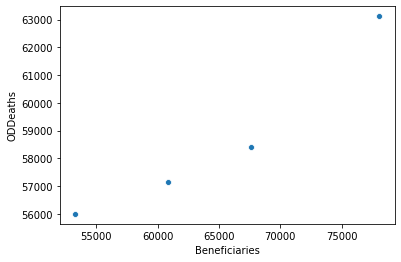

In [0]:
ax = sns.scatterplot(y="ODDeaths", x = "Beneficiaries", data=CA_MAT_OD)

In [0]:
stats.pearsonr(CA_MAT_OD['ODDeaths'], CA_MAT_OD['Beneficiaries'])

(0.9636496457992121, 0.036350354200787915)

Contrary to the hypothesis, OD deaths and MAT are positively correlated. However, we should look at number of people with OUD also.